In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import dask
import gcsfs
import xesmf as xe

In [2]:
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler

In [3]:
# Load in data sets
fs = gcsfs.GCSFileSystem(project='sipn2-pangeo', token='anon', access='read_only')
gcsmap = gcsfs.mapping.GCSMap('git_share/fine.zarr', gcs=fs, create=False)
ds_fine = xr.open_zarr(gcsmap)
ds_fine

<xarray.Dataset>
Dimensions:  (x: 582, x_b: 583, y: 156, y_b: 157)
Coordinates:
    lat      (y, x) float64 dask.array<shape=(156, 582), chunksize=(78, 291)>
    lat_b    (y_b, x_b) float64 dask.array<shape=(157, 583), chunksize=(79, 292)>
    lat_f    (y) float64 dask.array<shape=(156,), chunksize=(156,)>
    lon      (y, x) float64 dask.array<shape=(156, 582), chunksize=(78, 291)>
    lon_b    (y_b, x_b) float64 dask.array<shape=(157, 583), chunksize=(79, 292)>
    lon_f    (x) float64 dask.array<shape=(582,), chunksize=(582,)>
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_b      (x_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_b      (y_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    hi       (y, x) float64 dask.array<shape=(156, 582), chunksize=(78, 291)>

In [4]:
gcsmap = gcsfs.mapping.GCSMap('git_share/target.zarr', gcs=fs, create=False)
ds_target = xr.open_zarr(gcsmap)
ds_target

<xarray.Dataset>
Dimensions:  (ni: 448, ni_b: 449, nj: 304, nj_b: 305)
Coordinates:
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * ni_b     (ni_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * nj_b     (nj_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    lat      (nj, ni) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
    lat_b    (nj_b, ni_b) float64 dask.array<shape=(305, 449), chunksize=(153, 225)>
    lon      (nj, ni) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
    lon_b    (nj_b, ni_b) float64 dask.array<shape=(305, 449), chunksize=(153, 225)>
    mask     (nj, ni) bool dask.array<shape=(304, 448), chunksize=(304, 448)>

### The lat/lon bounds look right to me (here is just shown one corner)

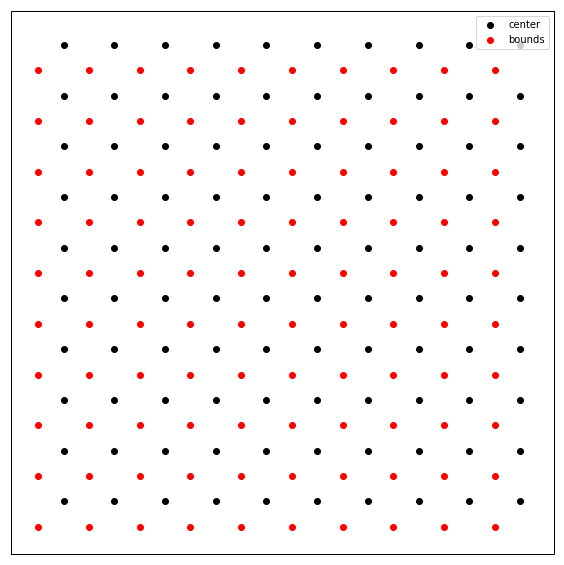

In [5]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.75, color='black', resolution='50m')
ax.scatter(ds_fine.lon[0:10,0:10],ds_fine.lat[0:10,0:10],color='k', transform=ccrs.PlateCarree(),label='center')
ax.scatter(ds_fine.lon_b[0:10,0:10],ds_fine.lat_b[0:10,0:10],color='r', transform=ccrs.PlateCarree(),label='bounds')
plt.legend()

In [7]:
# Add mask to ds_fine
ds_fine['mask'] = ds_fine.hi.notnull()

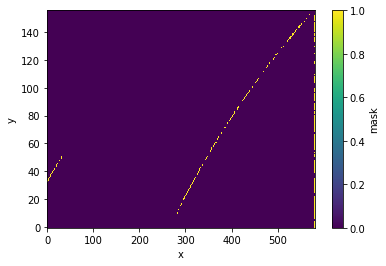

In [24]:
ds_fine.mask.plot()

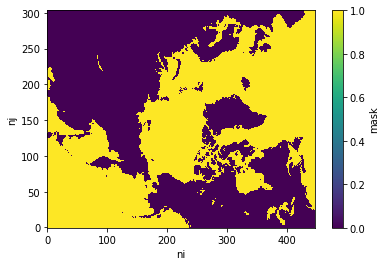

In [25]:
ds_target.mask.plot()

In [17]:
method = 'conservative_normed' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']
regridder = xe.Regridder(ds_fine, ds_target, method, periodic=False, reuse_weights='False')

(156, 582)
(304, 448)
Create weight file: conservative_normed_156x582_304x448.nc


In [26]:
cvar = 'hi'
offset = 10
ds_coarse = regridder(ds_fine[cvar]+10)
ds_coarse = ds_coarse.where(ds_coarse>(offset)) - offset
regridder.clean_weight_file()

File conservative_normed_156x582_304x448.nc is already removed.


### Plot the orginal fine data (its really sparse because data is from flight tracks)

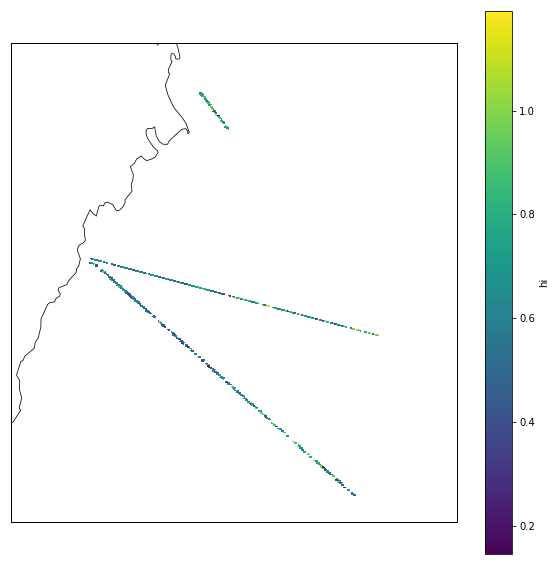

In [27]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.coastlines(linewidth=0.75, color='black', resolution='50m')
ds_fine[cvar].plot(x='lon',y='lat',transform=ccrs.PlateCarree())

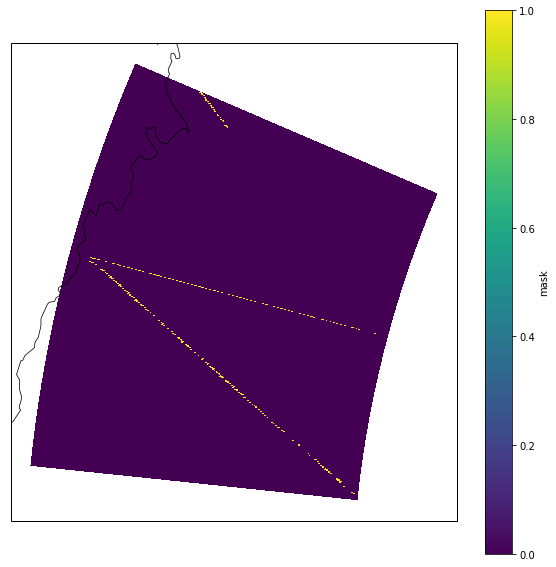

In [28]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.coastlines(linewidth=0.75, color='black', resolution='50m')
ds_fine['mask'].plot(x='lon',y='lat',transform=ccrs.PlateCarree())

### Plot the gridded output

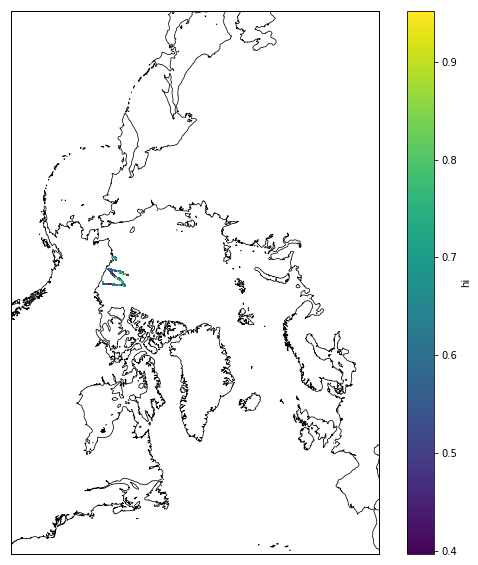

In [29]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.coastlines(linewidth=0.75, color='black', resolution='50m')
ds_coarse.plot(x='lon',y='lat',transform=ccrs.PlateCarree())

### Overlay fine on coarse (you can see where the tracks should be, the coarse data just has missing values (nans)

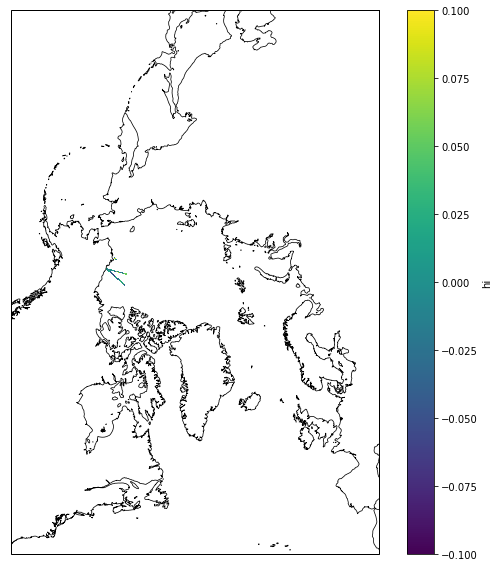

In [35]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.coastlines(linewidth=0.75, color='black', resolution='50m')
ds_coarse.plot(x='lon',y='lat',transform=ccrs.PlateCarree())
ds_fine[cvar].plot(x='lon',y='lat',transform=ccrs.PlateCarree(), add_colorbar=False)